[iter 300] train=1.117566e-02  valid=1.089531e-02
[iter 600] train=2.918210e-03  valid=2.851137e-03
[iter 900] train=2.336349e-03  valid=2.297403e-03
[iter 1200] train=2.133572e-03  valid=2.101289e-03
[iter 1500] train=1.971460e-03  valid=1.942216e-03
[iter 1800] train=1.831352e-03  valid=1.804357e-03
[iter 2100] train=1.709634e-03  valid=1.684622e-03
[iter 2400] train=1.603756e-03  valid=1.580567e-03
[iter 2700] train=1.511541e-03  valid=1.490043e-03
[iter 3000] train=1.431110e-03  valid=1.411182e-03
Test MSE = 1.421042e-03,  Test Max|err| = 1.114573e-01


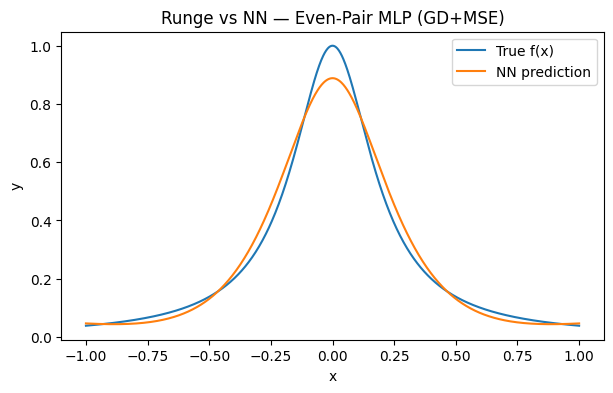

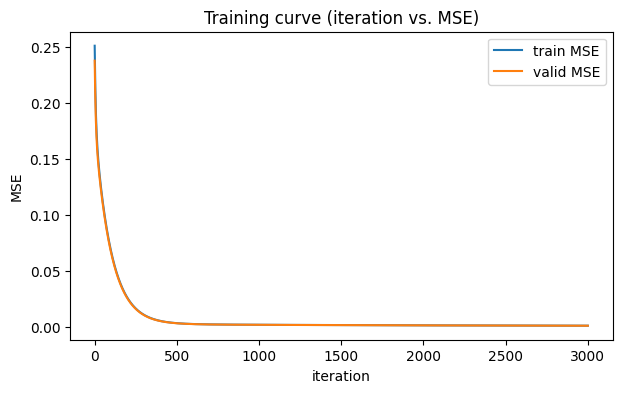

In [ ]:
# Colab cell：Even-Pair MLP for Runge (Batch GD + MSE, no Adam, use 'iteration')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# ----- data & target -----
def runge(x): return 1.0/(1.0+25.0*x*x)

def make_data(n_train=2000, n_valid=800, n_test=1001, seed=7):
    rng = np.random.default_rng(seed)
    Xtr = rng.uniform(-1.0, 1.0, n_train)
    Xva = rng.uniform(-1.0, 1.0, n_valid)
    Xte = np.linspace(-1.0, 1.0, n_test)
    return Xtr, runge(Xtr), Xva, runge(Xva), Xte, runge(Xte)

# ----- init (與你之前類似；維持非零 b1；適度放大 W2 讓前層梯度不太小) -----
def init_mlp(H=64, seed=42):
    rng = np.random.default_rng(seed)
    W1 = rng.normal(0.0, 2.5, size=H)
    b1 = rng.normal(0.0, 0.10, size=H)      # 非零偏置，破對稱
    V  = rng.normal(0.0, 0.5, size=H)       # 輸出層權重
    b2 = 0.0
    return W1, b1, V, b2

# ----- forward：偶函數化的隱藏層 h = tanh(wx+b) + tanh(-wx+b) -----
def forward(W1, b1, V, b2, x):
    z_pos = np.outer(x,  W1) + b1          # (N,H)
    z_neg = np.outer(-x, W1) + b1          # (N,H)  ← 共享同一組 W1,b1
    a_pos = np.tanh(z_pos)
    a_neg = np.tanh(z_neg)
    h = a_pos + a_neg                      # (N,H)  ← ★ 保證 h(-x)=h(x)
    yhat = b2 + h @ V                      # (N,)
    return yhat, (a_pos, a_neg, h)

def mse(yhat, y): return np.mean((yhat - y)**2)
def maxerr(yhat, y): return np.max(np.abs(yhat - y))

# ----- one GD step（向量化反傳；注意負分支的鏈式法則） -----
def step_gd(W1, b1, V, b2, X, Y, lr=3e-3):
    yhat, (a_pos, a_neg, h) = forward(W1, b1, V, b2, X)
    err = yhat - Y
    # dL/dV, dL/db2
    gV  = (h * err[:,None]).mean(axis=0)          # (H,)
    gb2 = err.mean()
    # 對兩個分支的誤差
    d_h = err[:,None] * V[None,:]                # (N,H)
    d_pos = d_h * (1.0 - a_pos*a_pos)            # (N,H)
    d_neg = d_h * (1.0 - a_neg*a_neg)            # (N,H)
    # dL/dW1：z_pos = W1*x + b1  → *x；  z_neg = W1*(-x) + b1 → *(-x)
    gW1 = (d_pos * X[:,None] + d_neg * (-X)[:,None]).mean(axis=0)  # (H,)
    gb1 = (d_pos + d_neg).mean(axis=0)                               # (H,)
    # 更新
    W1 -= lr*gW1;  b1 -= lr*gb1;  V -= lr*gV;  b2 -= lr*gb2
    return W1, b1, V, b2

def train(Xtr, Ytr, Xva, Yva, H=64, lr=3e-3, iterations=3000, seed=123, log_every=300):
    W1, b1, V, b2 = init_mlp(H=H, seed=seed)
    tr_hist, va_hist = [], []
    for t in range(1, iterations+1):
        W1, b1, V, b2 = step_gd(W1, b1, V, b2, Xtr, Ytr, lr=lr)
        ytr,_ = forward(W1, b1, V, b2, Xtr)
        yva,_ = forward(W1, b1, V, b2, Xva)
        tr_hist.append(mse(ytr, Ytr)); va_hist.append(mse(yva, Yva))
        if t % log_every == 0:
            print(f"[iter {t}] train={tr_hist[-1]:.6e}  valid={va_hist[-1]:.6e}")
    return (W1,b1,V,b2), np.array(tr_hist), np.array(va_hist)

# ----- run -----
def main():
    Xtr,Ytr,Xva,Yva,Xte,Yte = make_data()
    H, lr, iters = 64, 3e-3, 3000
    params, tr, va = train(Xtr,Ytr,Xva,Yva, H=H, lr=lr, iterations=iters)
    W1,b1,V,b2 = params
    Yhat,_ = forward(W1,b1,V,b2,Xte)

    print("Test MSE = %.6e,  Test Max|err| = %.6e" % (mse(Yhat,Yte), maxerr(Yhat,Yte)))

    # 圖…
    plt.figure(figsize=(7,4))
    plt.plot(Xte, Yte, label="True f(x)")
    plt.plot(Xte, Yhat, label="NN prediction")
    plt.title("Runge vs NN — Even-Pair MLP (GD+MSE)")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    it = np.arange(1, iters+1)
    plt.plot(it, tr, label="train MSE"); plt.plot(it, va, label="valid MSE")
    plt.title("Training curve (iteration vs. MSE)")
    plt.xlabel("iteration"); plt.ylabel("MSE"); plt.legend(); plt.show()

    # ★ 把需要在下一個 cell 用到的值回傳出去
    return Yhat, Yte, H, lr, iters


if __name__ == "__main__":
    Yhat, Yte, H, lr, iters = main()



In [ ]:
import numpy as np, pandas as pd
test_mse  = np.mean((Yhat - Yte)**2)
test_max  = np.max(np.abs(Yhat - Yte))
print("Test MSE =", test_mse, "  Test Max |err| =", test_max)
pd.DataFrame([{"H":H,"lr":lr,"iterations":iters,
              "Test MSE":float(test_mse),"Test Max |err|":float(test_max)}])\
  .to_csv("w2_summary.csv", index=False)


Test MSE = 0.0014210415470691194   Test Max |err| = 0.11145728012806644
